# **Kenya Airways Customer Review Sentiment Analysis**

![Kenya Airways Logo](https://upload.wikimedia.org/wikipedia/commons/thumb/7/75/Kenya_Airways_Logo.svg/598px-Kenya_Airways_Logo.svg.png?20111111111353)
### **Navigating this Repository**

### **Business Overview**
Kenya Airways is among the top airlines in Africa, and in Kenya, it holds a prominent position as the flag carrier and the largest airline in the country. Since its establishment in 1977, Kenya Airways has been a key player in both domestic and international air travel, connecting Kenya to various destinations around the world. The airline is known for its commitment to providing safe, reliable, and comfortable air travel experiences to its passengers. Over the years, Kenya Airways has built a strong brand reputation, emphasizing its African heritage and hospitality.

### **Project Overview**
The aim of this project is to conduct sentiment analysis on customer reviews related to Kenya Airways. By analyzing the sentiments expressed in these reviews, we seek to gain insights into how customers perceive their experiences with the airline's services. This analysis will provide valuable feedback that can be used to enhance customer satisfaction, identify areas for improvement, and make informed business decisions to maintain and improve the airline's reputation.


#### **Project Objectives**
1. **Sentiment Classification**: Develop a sentiment classification model that can accurately categorize customer reviews into positive, negative, or neutral sentiments. This model will help automate the process of analyzing large volumes of reviews.

2. **Feedback Analysis**: Identify common themes and specific aspects mentioned in the reviews, such as in-flight services, customer service, booking process, seating comfort, and more. This will provide a comprehensive understanding of what aspects are contributing to positive or negative sentiments.

#### **Success Metrics**


### **Data Understanding**
The data was scraped using BeautifulSoup from [this](https://www.airlinequality.com/airline-reviews/kenya-airways/) website. The website contains various reviews related to Air Travel. A total of 433 reviews were scraped ranging from the year to 2023.
#### **Feature Engineering and Selection**


### **Model Evaluation**

### **Conclusion**

### **Recommendations**


### **Next Steps**

## **Data Importation**

In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

import re
import nltk
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/kenya-airways/"
pages = 6
page_size = 100

reviews = []
date = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for review in parsed_content.find_all("article", {"itemprop": "review"}):
        # Extract review text
        review_text = review.find("div", {"class": "text_content"}).get_text()
        reviews.append(review_text)

        # Extract date
        try:
            review_date = review.find("div", {"class": "body"}).find("time").get_text()
        except AttributeError:
            review_date = "N/A"
        date.append(review_date)

    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 434 total reviews
Scraping page 6
   ---> 434 total reviews


In [3]:
# Create a Dataframe to store the data 

df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,Not Verified | The lady at check-in was very ...,26th August 2023
1,✅ Trip Verified | Dismal from start to end. N...,23rd August 2023
2,Not Verified | Airline was 1 hour late to boar...,22nd August 2023
3,✅ Trip Verified | Kenya Airways has really di...,19th August 2023
4,✅ Trip Verified | JNB-NBO-AMS-ZRH on 14-15 Au...,18th August 2023


In [4]:
# Saves the dataframe as a csv file in the data folder.

cwd = os.getcwd()
df.to_csv(cwd + "/data/KQ_reviews.csv") 

In [5]:
# Inspect index 0

df['reviews'].get(0)

"Not Verified |  The lady at check-in was very rude and insisted on wanting to check in my colleague on a 4am flight with no alternative accommodation but a mere 200usd and we  rejected the offer as it excluded accommodation. She refused to call the manager when we requested her to and brazenly carried on until we confronted her again. Only after waiting for 55 minutes then my colleague's seat was secured and we went through the boarding gates. As if that wasn't enough, the departure time was 30min late and no apology was received from the captain. To use Kenya Airways was the biggest blunder on my side ever committed. I am a frequent flyer and have never experienced such a distasteful and shabby treatment ever. I vow never to use this airline again."

In [6]:
# Class used to Describe the Data


class Describer:
    
    # initialize object
    def __init__(self, df):
        self.df = df
        
    # method to check shape of data
    def shape(self):
        shape_df = print(f"The DataFrame has:\n\t* {self.df.shape[0]} rows\n\t* {self.df.shape[1]} columns", '\n')
        return shape_df
    
    # method to check info on dataset
    def data_info(self):
        info_df = print(self.df.info(), '\n')
        return info_df
    
    # method to describe numerical columns
    def data_describe(self):
        num_col = self.df.describe()
        return num_col

In [7]:
# creating an instance of the class describer
describe_df = Describer(df)

# Viewing the shape of the data
describe_df.shape()

The DataFrame has:
	* 434 rows
	* 2 columns 



In [8]:
# summary information
print('Summary infomation on dataset')
print('-----------------------------------------------')
describe_df.data_info()

Summary infomation on dataset
-----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  434 non-null    object
 1   date     434 non-null    object
dtypes: object(2)
memory usage: 6.9+ KB
None 



### **Data Cleaning**

In [9]:
# checks the length of the column "reviews"
len(df['reviews']) 

434

There are 433 reviews that were scraped from the website.

In [10]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")

In [11]:
# Checks the percentage value of the content in this new column.
df['verified'].value_counts(normalize=True) 

verified
False    0.626728
True     0.373272
Name: proportion, dtype: float64

In [12]:
# Creates a new column that extracts the information on whether the trip is verified or not

reviews_data = df.reviews.str.strip("✅ Trip Verified |")  
corpus =[]
# Instantiate the WordNetLemmatizer
lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

In [13]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df

,reviews,date,verified,corpus
0,Not Verified | The lady at check-in was very ...,26th August 2023,False,verified lady check rude insisted wanting chec...
1,✅ Trip Verified | Dismal from start to end. N...,23rd August 2023,True,dismal start end staff crew rude sullen disint...
2,Not Verified | Airline was 1 hour late to boar...,22nd August 2023,False,verified airline hour late board passenger hou...
3,✅ Trip Verified | Kenya Airways has really di...,19th August 2023,True,kenya airway really disappointed second time n...
4,✅ Trip Verified | JNB-NBO-AMS-ZRH on 14-15 Au...,18th August 2023,True,jnb nbo am zrh august flight time despite quit...
...,...,...,...,...
429,JNB-NBO-JNB. This trip showed both the good an...,18th July 2011,False,jnb nbo jnb trip showed good average side airl...
430,Nairobi-London. Lounge in Nairobi was small an...,17th July 2011,False,nairobi london lounge nairobi small food poor ...
431,Nairobi-London. As me and my wife are both whe...,11th July 2011,False,nairobi london wife wheelchair passenger charg...
432,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,6th July 2011,False,lun llw economy adequate hr trip fa friendly q...


In [14]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(8)

,reviews,date,verified,corpus
0,Not Verified | The lady at check-in was very ...,26th August 2023,False,verified lady check rude insisted wanting chec...
1,Dismal from start to end. Not all of the staff...,23rd August 2023,True,dismal start end staff crew rude sullen disint...
2,Not Verified | Airline was 1 hour late to boar...,22nd August 2023,False,verified airline hour late board passenger hou...
3,Kenya Airways has really disappointed me for a...,19th August 2023,True,kenya airway really disappointed second time n...
4,JNB-NBO-AMS-ZRH on 14-15 August 23. Flights on...,18th August 2023,True,jnb nbo am zrh august flight time despite quit...
5,Officially the worlds worst airline. 3hr + del...,7th August 2023,True,officially world worst airline hr delay sa bur...
6,Not Verified | The worst service I have ever ...,31st July 2023,False,verified worst service ever encountered airlin...
7,Do not use Kenya Airways! This was the worst d...,27th July 2023,True,use kenya airway worst decision ever made two ...


In [15]:
# Convert the date column to date time

df['date'] = pd.to_datetime(df['date'].str.replace(r'(?<=\d)(st|nd|rd|th)', '', regex=True))


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviews   434 non-null    object        
 1   date      434 non-null    datetime64[ns]
 2   verified  434 non-null    bool          
 3   corpus    434 non-null    object        
dtypes: bool(1), datetime64[ns](1), object(2)
memory usage: 10.7+ KB


The `date` column has been converted to its appropriate data type. 

In [17]:
# Cleaned data 
df.to_csv( cwd + "/data/reviews_cleaned.csv")

## **Exploratory Data Analysis**

In [18]:
# an instance of SentimentIntensityAnalyzer
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

,reviews,date,verified,corpus,sentiment
0,Not Verified | The lady at check-in was very ...,2023-08-26,False,verified lady check rude insisted wanting chec...,-0.8909
1,Dismal from start to end. Not all of the staff...,2023-08-23,True,dismal start end staff crew rude sullen disint...,-0.9751
2,Not Verified | Airline was 1 hour late to boar...,2023-08-22,False,verified airline hour late board passenger hou...,-0.8899
3,Kenya Airways has really disappointed me for a...,2023-08-19,True,kenya airway really disappointed second time n...,-0.2952
4,JNB-NBO-AMS-ZRH on 14-15 August 23. Flights on...,2023-08-18,True,jnb nbo am zrh august flight time despite quit...,0.9520
...,...,...,...,...,...
429,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,False,jnb nbo jnb trip showed good average side airl...,0.8201
430,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,False,nairobi london lounge nairobi small food poor ...,0.9826
431,Nairobi-London. As me and my wife are both whe...,2011-07-11,False,nairobi london wife wheelchair passenger charg...,0.9485
432,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,False,lun llw economy adequate hr trip fa friendly q...,0.6808


In [19]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'sentiment' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df #inspect the dataframe

,reviews,date,verified,corpus,sentiment,sentiment_type
0,Not Verified | The lady at check-in was very ...,2023-08-26,False,verified lady check rude insisted wanting chec...,-0.8909,negative
1,Dismal from start to end. Not all of the staff...,2023-08-23,True,dismal start end staff crew rude sullen disint...,-0.9751,negative
2,Not Verified | Airline was 1 hour late to boar...,2023-08-22,False,verified airline hour late board passenger hou...,-0.8899,negative
3,Kenya Airways has really disappointed me for a...,2023-08-19,True,kenya airway really disappointed second time n...,-0.2952,negative
4,JNB-NBO-AMS-ZRH on 14-15 August 23. Flights on...,2023-08-18,True,jnb nbo am zrh august flight time despite quit...,0.9520,positive
...,...,...,...,...,...,...
429,JNB-NBO-JNB. This trip showed both the good an...,2011-07-18,False,jnb nbo jnb trip showed good average side airl...,0.8201,positive
430,Nairobi-London. Lounge in Nairobi was small an...,2011-07-17,False,nairobi london lounge nairobi small food poor ...,0.9826,positive
431,Nairobi-London. As me and my wife are both whe...,2011-07-11,False,nairobi london wife wheelchair passenger charg...,0.9485,positive
432,LUN-LLW in Economy. Adequate for a 1 hr trip. ...,2011-07-06,False,lun llw economy adequate hr trip fa friendly q...,0.6808,positive


In [20]:
# calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True)
sent_type_percentages

sentiment_type
negative    0.516129
positive    0.483871
Name: proportion, dtype: float64

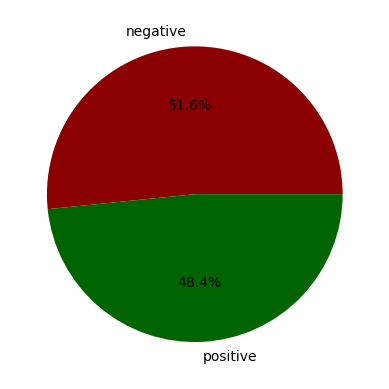

In [21]:
# Plot the sentiment percentages 
fig, ax = plt.subplots()
ax.pie(
    sent_type_percentages,
    labels=sent_type_percentages.index, 
    colors=['darkred', 'darkgreen'], 
    autopct='%1.1f%%'
    )

plt.show()

Negative reviews account for 52% of the dataset, and positive reviews account for 49% of the dataset. <br>Understanding what is the reason behind the negative reviews is the main concern of this project.

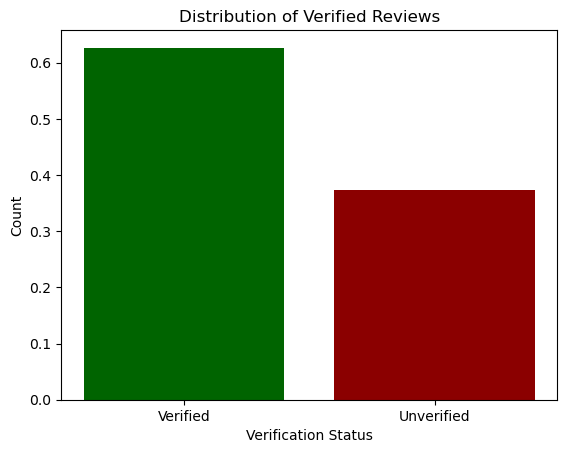

In [22]:
# Calculate the counts of verified and unverified reviews
verified_counts = df['verified'].value_counts(normalize= True)

# Create the bar chart
plt.bar(verified_counts.index, verified_counts.values, color=['darkgreen', 'darkred'])

# Add labels and title
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.title('Distribution of Verified Reviews')

# Customize x-axis tick labels
plt.xticks(verified_counts.index, ['Verified', 'Unverified'])

# Show the plot
plt.show()

Majority of the reviews have been verified. 

In [23]:
# Time Series Analysis on the Date column
fig = px.line(df, x='date')
fig.show()

There is a decline on the number of reviews that have been shared.

In [24]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words 

words = []
for review in reviews:
    words.extend(review.split())
    

# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]


In [25]:
# Get the top 20 most used words 
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words 
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]


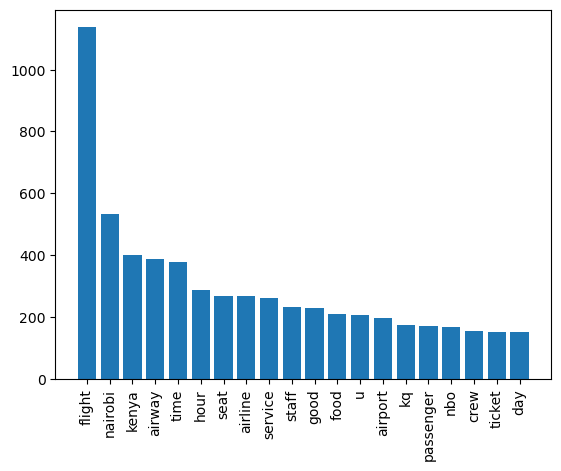

In [26]:
# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()


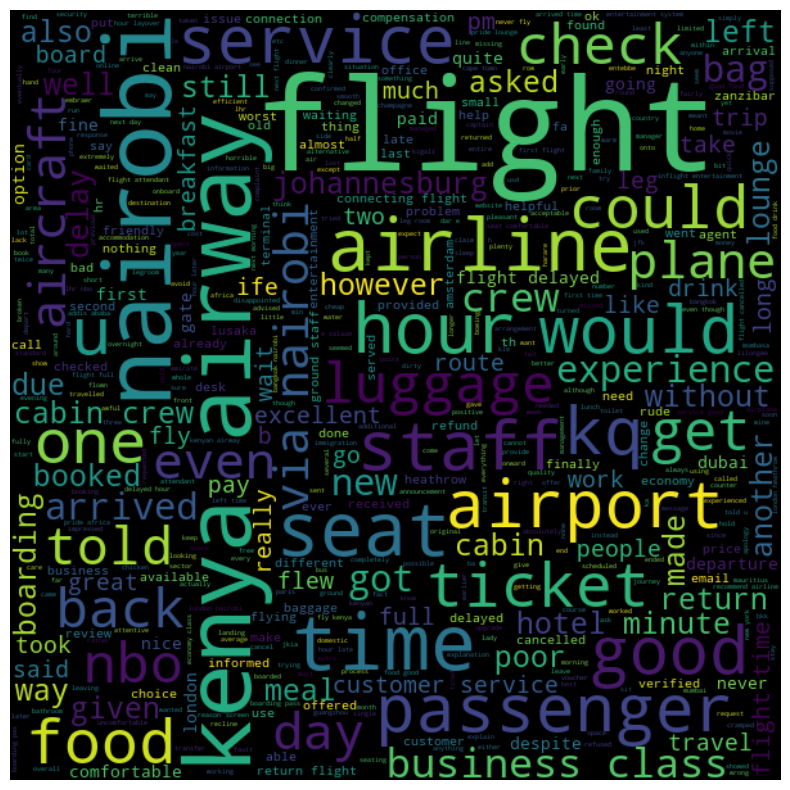

In [27]:
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'kq', "passenger","u","airway","airline",
                                           "nairobi","plane","via","nbo"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

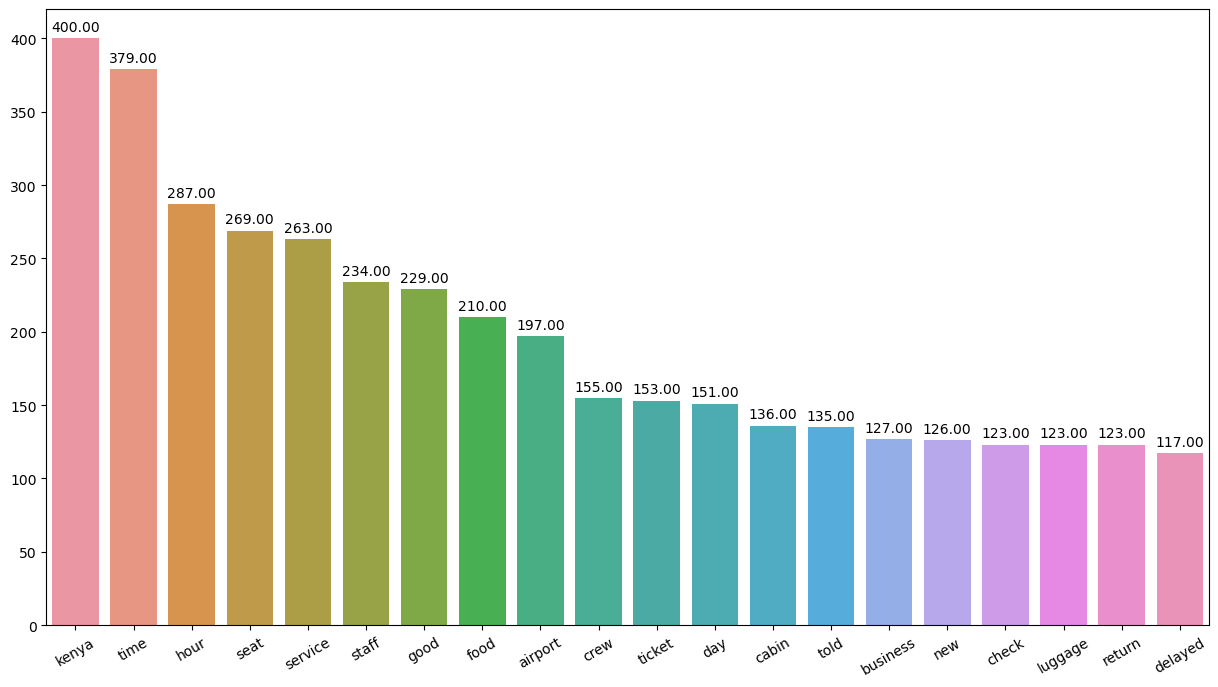

In [29]:
# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15, 8))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)

# Add labels to the bars
for container in all_plot.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=30)

# Display the plot
plt.show()

### **Word Frequency using N-gram**

<Axes: >

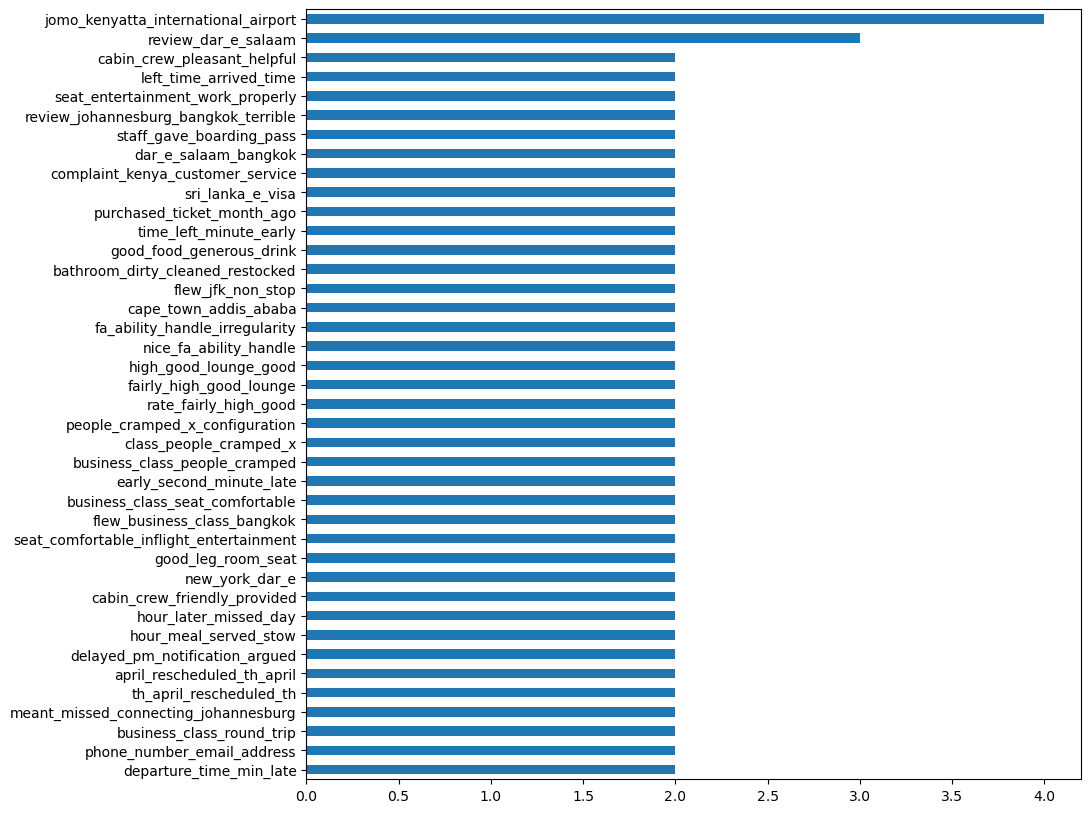

In [30]:
reviews = " ".join(df.corpus)

# Split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words, number_of_ngrams):
    # Generate n-grams
    ngrams_list = list(ngrams(new_words, number_of_ngrams))

    # Creating FreqDist
    ngram_fd = FreqDist(ngrams_list).most_common(40)

    # Sort values by highest frequency
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Join n-gram tokens with '_' and maintain sorting
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Convert to Pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words, 4)


In [31]:
df['sentiment_type'].unique()

array(['negative', 'positive'], dtype=object)

In [32]:
df['sentiment']

0     -0.8909
1     -0.9751
2     -0.8899
3     -0.2952
4      0.9520
        ...  
429    0.8201
430    0.9826
431    0.9485
432    0.6808
433    0.4921
Name: sentiment, Length: 434, dtype: float64

In [33]:
%%capture
vds = SentimentIntensityAnalyzer()

df['label'] = 0
    
for i in range(len(df.corpus)):
    
    score = vds.polarity_scores(df.corpus[i])['compound']
    # Positive sentiments
    if score > 0.2:
        df['label'][i] = 1
        # Negative sentiments 
    elif score < 0:
        df['label'][i] = -1



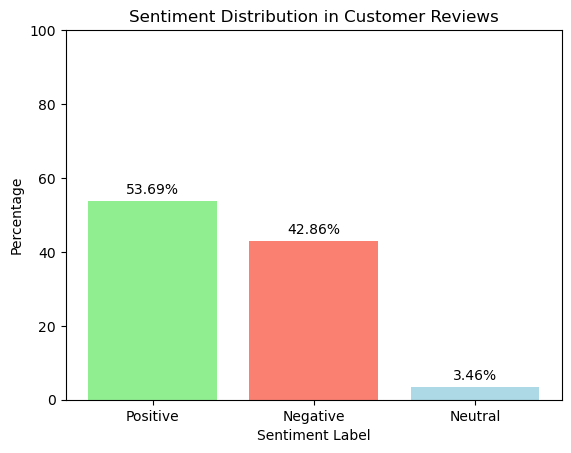

In [34]:
# Calculate label distribution percentages
label_percentages = df.label.value_counts(normalize=True) * 100

# Bar chart
colors = ['lightgreen', 'salmon', 'lightblue']
labels = ['Positive', 'Negative', 'Neutral']

plt.bar(labels, label_percentages, color=colors)
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage')
plt.title('Sentiment Distribution in Customer Reviews')
plt.ylim(0, 100)

# Display percentages on the bars
for i, percentage in enumerate(label_percentages):
    plt.text(i, percentage + 2, f"{percentage:.2f}%", ha='center', color='black')

plt.show()

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [36]:
#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic = pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights
0,flight,71.1,flight,303.3,flight,132.2,flight,251.2,flight,94.6,flight,115.9,nairobi,32.4,flight,144.7
1,nairobi,48.1,kenya,189.1,seat,57.2,nairobi,102.1,nairobi,53.8,good,61.9,kenya,28.4,time,73.5
2,time,45.8,airway,179.7,time,47.8,hour,86.5,good,48.3,seat,54.4,airway,28.1,nairobi,64.1
3,food,39.4,nairobi,151.0,nairobi,47.7,day,76.1,seat,47.7,kq,46.4,flight,25.0,luggage,57.5
4,service,31.2,airline,105.7,service,45.3,kenya,68.2,food,45.7,time,43.8,good,23.1,seat,49.3
5,meal,27.2,hour,77.7,crew,45.0,airport,67.6,nbo,40.7,food,42.0,staff,21.3,class,45.3
6,seat,26.1,service,71.8,airway,43.9,told,65.9,time,39.7,entertainment,37.1,lounge,19.7,kq,44.1
7,breakfast,24.9,customer,62.9,kenya,42.7,airway,62.0,crew,38.3,nairobi,36.7,time,19.5,passenger,43.9
8,good,24.8,fly,58.6,hour,39.2,time,57.9,return,37.2,nbo,35.3,airline,17.6,business,42.7
9,nbo,21.1,one,52.4,airline,37.0,ticket,52.9,back,35.0,new,32.1,food,16.6,good,40.6


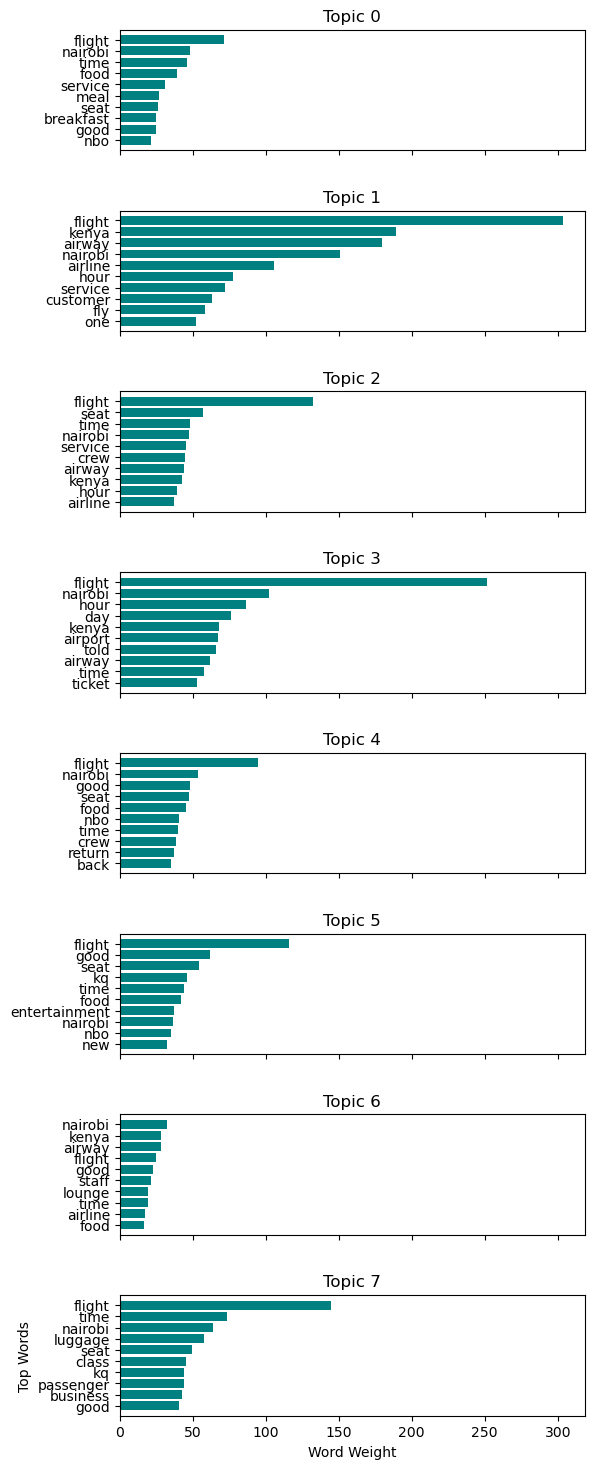

In [37]:
# Create subplots for each topic
fig, axes = plt.subplots(number_of_topics, 1, figsize=(6, 18), sharex=True)
plt.subplots_adjust(hspace=0.5)

for topic_idx in range(number_of_topics):
    words = topic_dict["Topic %d words" % (topic_idx)]
    weights = [float(w) for w in topic_dict["Topic %d weights" % (topic_idx)]]
    
    axes[topic_idx].barh(words, weights, color='teal')
    axes[topic_idx].set_title(f"Topic {topic_idx}")
    axes[topic_idx].invert_yaxis()  

plt.xlabel('Word Weight')
plt.ylabel('Top Words')
plt.show()


### **Topic modeling with NMF**

In [38]:
nmf = NMF(n_components=2, init='random', random_state=0)
nmf.fit_transform(tf)

array([[5.69895277e-02, 4.40814782e-02],
       [2.69121806e-02, 6.79786239e-02],
       [7.53203218e-02, 6.49350007e-02],
       [4.93571938e-02, 1.17404040e-02],
       [0.00000000e+00, 5.93913436e-01],
       [4.82345122e-02, 5.13584776e-02],
       [9.97270250e-02, 8.91755193e-02],
       [1.54637004e-01, 0.00000000e+00],
       [7.82395345e-02, 6.48116597e-03],
       [4.25163235e-02, 5.09752599e-02],
       [5.80272681e-02, 2.46207326e-01],
       [2.00577034e-01, 1.04296028e-01],
       [6.68669272e-02, 1.78683734e-01],
       [6.81042879e-02, 6.18706663e-02],
       [6.37154399e-02, 1.12712248e-01],
       [9.42211863e-02, 0.00000000e+00],
       [4.24608491e-01, 0.00000000e+00],
       [3.46481079e-01, 5.95327531e-02],
       [1.43912853e-01, 2.64849661e-01],
       [7.97116314e-02, 0.00000000e+00],
       [1.28911765e-01, 1.02838491e-01],
       [0.00000000e+00, 1.00211505e-01],
       [1.98410223e-01, 5.98900285e-01],
       [3.58544617e-01, 1.41846551e-02],
       [1.221956

In [39]:
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,flight,18.2,flight,8.9
1,kenya,10.3,seat,5.0
2,airway,10.2,time,4.6
3,nairobi,7.1,good,4.1
4,hour,5.4,nairobi,3.8
5,ticket,4.7,food,3.4
6,airport,4.0,nbo,3.1
7,would,4.0,kq,2.8
8,told,3.8,service,2.5
9,day,3.6,class,2.4


## **Modeling**

#### **Logistic Regression**

In [40]:
# Convert continuous sentiment scores to categorical labels
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x > 0.2 else (-1 if x < 0 else 0))
df['sentiment'].value_counts(normalize=True)

sentiment
-1    0.516129
 1    0.460829
 0    0.023041
Name: proportion, dtype: float64

In [41]:
# Training and Test split

X = df['corpus']  # Features
y = df['sentiment']   # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Feature Extraction

vect = CountVectorizer()
x_train_vect = vect.fit_transform(X_train)
x_test_vect = vect.transform(X_test)

In [43]:
# Instantiate Logistic Regression

model = LogisticRegression()
model.fit(x_train_vect, y_train)

LogisticRegression()

In [44]:
# Model Evaluation
y_pred = model.predict(x_test_vect)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on test data: 0.82
Classification Report:
              precision    recall  f1-score   support

          -1       0.83      0.86      0.84        50
           0       0.00      0.00      0.00         1
           1       0.80      0.78      0.79        36

    accuracy                           0.82        87
   macro avg       0.54      0.55      0.54        87
weighted avg       0.81      0.82      0.81        87



### **Decision Tree Model**

In [45]:
# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train_vect, y_train)

# Model Evaluation

dt_y_pred = dt_model.predict(x_test_vect)
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.2f}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_y_pred))


Decision Tree Accuracy: 0.61
Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       0.70      0.60      0.65        50
           0       0.00      0.00      0.00         1
           1       0.56      0.64      0.60        36

    accuracy                           0.61        87
   macro avg       0.42      0.41      0.41        87
weighted avg       0.63      0.61      0.62        87



### **Random Forest Model**

In [46]:
# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(x_train_vect, y_train)

# Model Evaluation

rf_y_pred = rf_model.predict(x_test_vect)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))


Random Forest Accuracy: 0.79
Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.82      0.82        50
           0       0.00      0.00      0.00         1
           1       0.76      0.78      0.77        36

    accuracy                           0.79        87
   macro avg       0.53      0.53      0.53        87
weighted avg       0.78      0.79      0.79        87



### **Support Vector Machine Model**

In [47]:
# Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(x_train_vect, y_train)

# Model Evaluation

svm_y_pred = svm_model.predict(x_test_vect)
svm_accuracy = accuracy_score(y_test, svm_y_pred)
print(f"SVM Accuracy: {svm_accuracy:.2f}")
print("SVM Classification Report:")
print(classification_report(y_test, svm_y_pred))

SVM Accuracy: 0.79
SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.82      0.82      0.82        50
           0       0.00      0.00      0.00         1
           1       0.76      0.78      0.77        36

    accuracy                           0.79        87
   macro avg       0.53      0.53      0.53        87
weighted avg       0.78      0.79      0.79        87



### **XGBoost Model**

In [48]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder to transform class labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=0, n_jobs=-1)
grid_search.fit(x_train_vect, y_train_encoded)

# Get the best tuned model
best_xgb_model = grid_search.best_estimator_

# Predict on the test data using the best model
xgb_y_pred_encoded = best_xgb_model.predict(x_test_vect)

# Decode the predicted labels to their original values
xgb_y_pred = label_encoder.inverse_transform(xgb_y_pred_encoded)

# Evaluate the model's performance
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_classification_rep = classification_report(y_test, xgb_y_pred)

print(f"Best XGBoost Model Accuracy: {xgb_accuracy:.2f}")
print("XGBoost Classification Report:")
print(xgb_classification_rep)


Best XGBoost Model Accuracy: 0.75
XGBoost Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.76      0.78        50
           0       0.00      0.00      0.00         1
           1       0.69      0.75      0.72        36

    accuracy                           0.75        87
   macro avg       0.49      0.50      0.50        87
weighted avg       0.74      0.75      0.74        87

